# Задача "Прогноз состава сырья"

## Описание задачи
На нефтехимические заводы СИБУР сырье (широкая фракция легких углеводородов - ШФЛУ) поступает по трубопроводу. Трубопровод наполняется на нескольких станциях подкачки, которые расположены последовательно на пути к потребителю.

Состав ШФЛУ меняется на каждой станции с течением времени и, таким образом, меняется итоговый состав ШФЛУ, которую получает потребитель. Имея достоверный прогноз по составу можно оптимизировать некоторые технологические процессы.

Вам предстоит построить прогноз состава поступающей по трубопроводу ШФЛУ на основании данных с последней перед потребителем станции подкачки. При этом геометрия трубопровода, расстояние от станции подкачки до потребителя и другие параметры трубопровода не раскрываются.

Метрикой в этой задаче служит средняя по всем целевым переменным MAPE.

## Данные
Данные содержат расходы сырья в т/ч для станции подкачки A (A_rate) и потребителя B (B_rate), а также массовые процентные доли различных компонент на станции A (A_CH4, A_C2H6, A_C3H8, A_iC4H10, A_nC4H10, A_iC5H12, A_nC5H12, A_C6H14).

Целевые переменные: массовые процентные доли нескольких компонент на станции B (B_C2H6, B_C3H8, B_iC4H10, B_nC4H10). Целевые переменные для тестового периода не содержат разрывов, поэтому загружаемое решение должно содержать все временные метки из тестового множества.

train_targets.csv - целевые переменные для тренировочного множества
train_features.csv - признаки для тренировочного множества
test_features.csv - признаки для тестового множества
sample_submission.csv - пример решения в правильном формате

## Вебинар
На вебинаре организаторы разъяснили немного условия задачи.
Есть трубопровод по которому подается ШФЛУ из сечения А в сечение В. По пути из А в В присутствует подкачка ШФЛУ более-менее стабильного состава. Расход данной подкачки можно определить на основании данных в условии задачи расходов в А и В.

G - массовый расход ШФЛУ, х - процентный массовый состав ШФЛУ по каждому компоненту

<center>
<img src="Schem.jpg">

Первое что приходит в голову - задача на **структуру потоков**.

Если бы были данные по устройству трубопровода (геометрия, топология, арматура), температура и давление ШФЛУ, результаты гидродинамических испытаний по структуре потока (кривые распределения времени пребывания, плотности распределения, кривые отклика) можно было бы попытаться создать модель (ячеечную или диффузионную), а также попробовать её решить численно, либо создать гибридную модель. Но данных таких нет и не всегда они бывают даже у датасайнтистов из Сибура...
    
    
Кстати, в интернете нашел интересную статью как раз по моделированию смешения и коэффициента продольного перемешивания (эффективная диффузия) - "*Новый метод расчета многопродуктовых магистральных
трубопроводов*", А.С. Дидковская

## Посмотрим на данные

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import math as m

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cbook as cbook
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
train_features = pd.read_csv('train_features.csv', header = 0, sep = ',')
test_features = pd.read_csv('test_features.csv', header = 0, sep = ',')
train_target = pd.read_csv('train_targets.csv', header = 0, sep = ',')

In [4]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

In [5]:
train_features[:]

timestamp     A_rate     A_CH4    A_C2H6     A_C3H8  \
0     2020-01-01 00:00:00  70.855017       NaN       NaN        NaN   
1     2020-01-01 00:30:00  70.826582       NaN       NaN        NaN   
2     2020-01-01 01:00:00  70.809637       NaN       NaN        NaN   
3     2020-01-01 01:30:00  69.994748       NaN       NaN        NaN   
4     2020-01-01 02:00:00  70.072762       NaN       NaN        NaN   
...                   ...        ...       ...       ...        ...   
5803  2020-04-30 21:30:00  72.009730  0.284151  4.936343  35.758852   
5804  2020-04-30 22:00:00  71.854180  0.282501  4.960453  35.877193   
5805  2020-04-30 22:30:00  71.783273  0.277686  5.013878  36.271557   
5806  2020-04-30 23:00:00  71.717743  0.271106  5.080144  36.616673   
5807  2020-04-30 23:30:00  71.730325  0.265635  5.069165  36.602453   

       A_iC4H10   A_nC4H10  A_iC5H12  A_nC5H12   A_C6H14     B_rate  
0           NaN        NaN       NaN       NaN       NaN  71.982789  
1           NaN        NaN       NaN       NaN       NaN  71.965098  
2           NaN        NaN       NaN       NaN       NaN  71.867409  
3           NaN        NaN       NaN       NaN       NaN  71.839126  
4           NaN        NaN       NaN       NaN       NaN  71.336921  
...         ...        ...       ...       ...       ...        ...  
5803  16.473834  24.318968  6.069360  5.527463  6.577563  74.183355  
5804  16.448487  24.074193  5.981357  5.407256  6.915378  74.213066  
5805  16.500147  24.010123  5.829363  5.160329  6.884173  74.144367  
5806  16.559533  24.008848  5.750492  5.017941  6.642076  74.320575  
5807  16.649167  24.150503  5.752792  4.997528  6.459137  74.327170  

[5808 rows x 11 columns]

In [6]:
train_features.corr()

A_rate     A_CH4    A_C2H6    A_C3H8  A_iC4H10  A_nC4H10  \
A_rate    1.000000  0.140528  0.437019  0.418836  0.017336 -0.430159   
A_CH4     0.140528  1.000000  0.335366  0.200776 -0.154180 -0.337805   
A_C2H6    0.437019  0.335366  1.000000  0.527549 -0.100987 -0.701938   
A_C3H8    0.418836  0.200776  0.527549  1.000000  0.486148 -0.709767   
A_iC4H10  0.017336 -0.154180 -0.100987  0.486148  1.000000  0.199295   
A_nC4H10 -0.430159 -0.337805 -0.701938 -0.709767  0.199295  1.000000   
A_iC5H12 -0.399400 -0.150923 -0.514814 -0.940113 -0.645688  0.546690   
A_nC5H12 -0.367528 -0.155106 -0.540416 -0.930008 -0.659884  0.523956   
A_C6H14  -0.318311 -0.128191 -0.407348 -0.881589 -0.686246  0.384840   
B_rate    0.962491  0.051154  0.341268  0.231222 -0.167036 -0.273329   

          A_iC5H12  A_nC5H12   A_C6H14    B_rate  
A_rate   -0.399400 -0.367528 -0.318311  0.962491  
A_CH4    -0.150923 -0.155106 -0.128191  0.051154  
A_C2H6   -0.514814 -0.540416 -0.407348  0.341268  
A_C3H8   -0.940113 -0.930008 -0.881589  0.231222  
A_iC4H10 -0.645688 -0.659884 -0.686246 -0.167036  
A_nC4H10  0.546690  0.523956  0.384840 -0.273329  
A_iC5H12  1.000000  0.975426  0.862518 -0.224065  
A_nC5H12  0.975426  1.000000  0.877563 -0.178315  
A_C6H14   0.862518  0.877563  1.000000 -0.122962  
B_rate   -0.224065 -0.178315 -0.122962  1.000000

In [7]:
train_features.describe()

A_rate        A_CH4       A_C2H6       A_C3H8     A_iC4H10  \
count  5807.000000  4849.000000  4849.000000  4849.000000  4849.000000   
mean     59.346948     0.159890     4.290739    37.990406    17.343168   
std      20.684895     0.068488     0.912565     3.756424     0.754301   
min       0.000321     0.008045     0.280524    11.345740    11.143152   
25%      61.846908     0.109331     3.971011    37.647968    17.018272   
50%      67.010148     0.139924     4.485758    38.618187    17.327200   
75%      69.734038     0.212163     4.844390    39.402360    17.685803   
max      74.560399     0.471429     6.418897    42.860283    20.353500   

          A_nC4H10     A_iC5H12     A_nC5H12      A_C6H14       B_rate  
count  4849.000000  4849.000000  4849.000000  4849.000000  5675.000000  
mean     24.413897     4.948636     4.809805     5.995740    64.817202  
std       1.274795     1.230539     1.285549     1.543956    10.696414  
min      18.655932     3.033678     1.338103     2.924722     0.000000  
25%      23.746663     4.462670     4.353103     5.574106    63.852030  
50%      24.138643     4.684908     4.619459     5.708216    68.583359  
75%      24.615843     5.086816     4.925770     6.032535    71.171153  
max      35.498867    13.812560    14.845480    30.656385    89.958390

In [8]:
train_features.isnull().sum()

timestamp      0
A_rate         1
A_CH4        959
A_C2H6       959
A_C3H8       959
A_iC4H10     959
A_nC4H10     959
A_iC5H12     959
A_nC5H12     959
A_C6H14      959
B_rate       133
dtype: int64

In [9]:
train_features.info()
train_features.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5808 entries, 0 to 5807
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  5808 non-null   object 
 1   A_rate     5807 non-null   float64
 2   A_CH4      4849 non-null   float64
 3   A_C2H6     4849 non-null   float64
 4   A_C3H8     4849 non-null   float64
 5   A_iC4H10   4849 non-null   float64
 6   A_nC4H10   4849 non-null   float64
 7   A_iC5H12   4849 non-null   float64
 8   A_nC5H12   4849 non-null   float64
 9   A_C6H14    4849 non-null   float64
 10  B_rate     5675 non-null   float64
dtypes: float64(10), object(1)
memory usage: 499.2+ KB


(5808, 11)

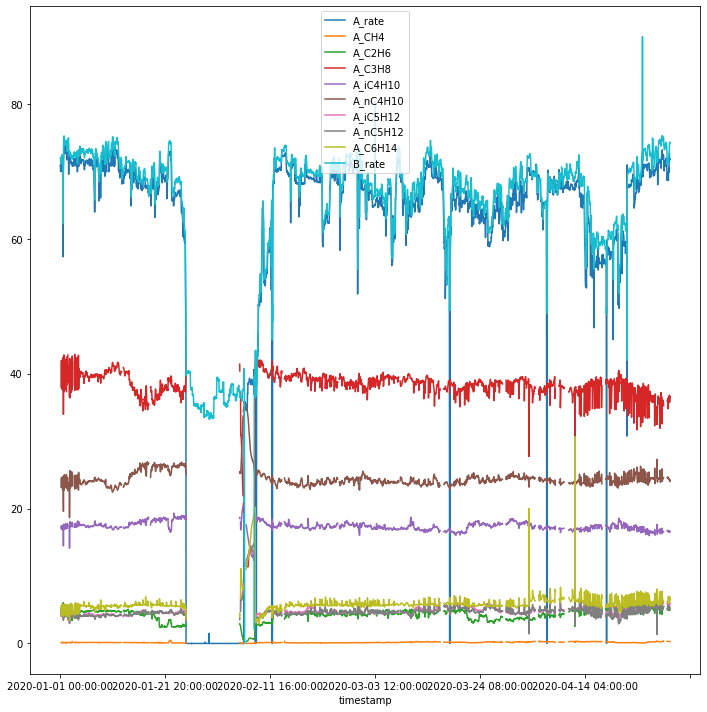

In [10]:
plt.rcParams["figure.figsize"] = (10,10)

train_features[:].plot('timestamp')

# make room for tick labels
plt.tight_layout()


plt.show()

In [11]:
train_features[train_features["A_rate"] <= 40]

timestamp     A_rate     A_CH4    A_C2H6     A_C3H8  \
1197  2020-01-25 22:30:00  37.634787  0.068959  2.783333  39.613317   
1198  2020-01-25 23:00:00   0.001294  0.070249  2.903388  41.168760   
1199  2020-01-25 23:30:00   0.001701  0.071737  2.994731  41.935570   
1200  2020-01-26 00:00:00   0.001525       NaN       NaN        NaN   
1201  2020-01-26 00:30:00   0.001055       NaN       NaN        NaN   
...                   ...        ...       ...       ...        ...   
5201  2020-04-18 08:30:00  39.827838  0.240746  5.309529  38.752616   
5202  2020-04-18 09:00:00   0.002014  0.247586  5.250514  38.680070   
5203  2020-04-18 09:30:00   0.001633  0.261290  4.818443  38.907820   
5204  2020-04-18 10:00:00  38.215334  0.276025  4.567278  38.848842   
5396  2020-04-22 10:00:00  30.749718  0.110907  5.681407  38.414870   

       A_iC4H10   A_nC4H10  A_iC5H12  A_nC5H12   A_C6H14     B_rate  
1197  18.374810  25.521723  4.473425  3.987337  5.163005  45.833590  
1198  18.650220  25.298560  4.232059  3.601516  4.062176  42.446206  
1199  18.765710  25.119170  4.089573  3.390231  3.620386  39.727496  
1200        NaN        NaN       NaN       NaN       NaN  39.972873  
1201        NaN        NaN       NaN       NaN       NaN  40.089745  
...         ...        ...       ...       ...       ...        ...  
5201  17.415626  24.286268  4.272327  4.035304  5.629434  56.099281  
5202  17.369883  24.286207  4.326687  4.089799  5.691831  48.813637  
5203  17.416410  24.441860  4.462670  4.187992  5.451690  49.964670  
5204  17.454773  24.491840  4.555090  4.260572  5.496899  48.964665  
5396  17.581315  24.102620  4.432917  3.888675  5.740080  54.846246  

[694 rows x 11 columns]

In [12]:
test_features

timestamp     A_rate     A_CH4    A_C2H6     A_C3H8  \
0     2020-05-01 00:00:00  71.428342  0.267832  5.135159  36.816480   
1     2020-05-01 00:30:00  70.925118  0.268464  5.149646  36.869023   
2     2020-05-01 01:00:00  70.991719  0.270641  5.154615  37.074965   
3     2020-05-01 01:30:00  70.972406  0.275241  5.230661  37.384180   
4     2020-05-01 02:00:00  70.980078  0.275062  5.241437  37.448587   
...                   ...        ...       ...       ...        ...   
3979  2020-07-22 21:30:00  72.600912  0.120985  4.328092  40.875930   
3980  2020-07-22 22:00:00  72.107049  0.110734  4.013567  38.871418   
3981  2020-07-22 22:30:00  71.805799  0.111535  4.041506  39.794323   
3982  2020-07-22 23:00:00  72.112046  0.119362  4.131432  40.461503   
3983  2020-07-22 23:30:00  72.941085  0.122393  4.207615  40.957330   

       A_iC4H10   A_nC4H10  A_iC5H12  A_nC5H12   A_C6H14     B_rate  
0     16.632260  24.062587  5.696004  4.939430  6.395286  74.273009  
1     16.651870  24.069800  5.676384  4.911872  6.346957  74.061833  
2     16.710967  24.106152  5.574873  4.808516  6.242636  73.856268  
3     16.683337  24.021993  5.514843  4.730887  6.101647  73.750744  
4     16.663863  24.003237  5.524898  4.728882  6.057119  73.698447  
...         ...        ...       ...       ...       ...        ...  
3979  17.741460  24.098520  4.469224  3.619095  4.686205  75.486026  
3980  17.449352  24.049532  4.770699  3.988215  6.689777  75.370451  
3981  17.635380  24.169473  4.613603  3.790651  5.785216  74.985878  
3982  17.758833  24.211013  4.504242  3.657459  5.094626  74.766867  
3983  17.772225  24.088445  4.387957  3.536302  4.863965  74.804667  

[3984 rows x 11 columns]

In [13]:
test_features.isnull().sum()

timestamp       0
A_rate       1142
A_CH4         456
A_C2H6        451
A_C3H8        452
A_iC4H10      452
A_nC4H10      452
A_iC5H12      456
A_nC5H12      456
A_C6H14       455
B_rate          5
dtype: int64

In [14]:
test_features.info()
test_features.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3984 entries, 0 to 3983
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  3984 non-null   object 
 1   A_rate     2842 non-null   float64
 2   A_CH4      3528 non-null   float64
 3   A_C2H6     3533 non-null   float64
 4   A_C3H8     3532 non-null   float64
 5   A_iC4H10   3532 non-null   float64
 6   A_nC4H10   3532 non-null   float64
 7   A_iC5H12   3528 non-null   float64
 8   A_nC5H12   3528 non-null   float64
 9   A_C6H14    3529 non-null   float64
 10  B_rate     3979 non-null   float64
dtypes: float64(10), object(1)
memory usage: 342.5+ KB


(3984, 11)

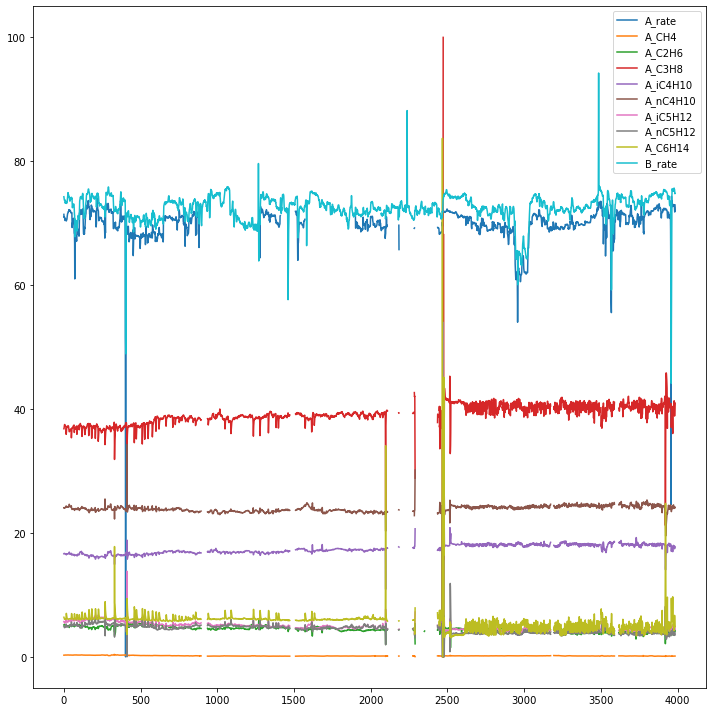

In [15]:
plt.rcParams["figure.figsize"] = (10,10)

test_features[:].plot()

# make room for tick labels
plt.tight_layout()


plt.show()

In [16]:
train_target

timestamp    B_C2H6     B_C3H8   B_iC4H10   B_nC4H10
0     2020-01-01 00:00:00  4.561979  39.015486  17.250740  24.301793
1     2020-01-01 00:30:00  4.550741  39.048915  17.229506  24.257461
2     2020-01-01 01:00:00  4.506793  38.766378  17.171621  24.236298
3     2020-01-01 01:30:00  4.584963  39.069360  17.218521  24.149843
4     2020-01-01 02:00:00  4.607483  38.817579  17.108668  24.049510
...                   ...       ...        ...        ...        ...
5803  2020-04-30 21:30:00  4.816865  35.539156  16.269938  24.770377
5804  2020-04-30 22:00:00  4.993286  36.067750  16.317757  24.729847
5805  2020-04-30 22:30:00  5.101574  36.275040  16.295460  24.629889
5806  2020-04-30 23:00:00  5.210675  36.872917  16.336359  24.438236
5807  2020-04-30 23:30:00  5.136487  35.860326  16.101509  24.426845

[5808 rows x 5 columns]

In [17]:
train_features.isnull().sum()

timestamp      0
A_rate         1
A_CH4        959
A_C2H6       959
A_C3H8       959
A_iC4H10     959
A_nC4H10     959
A_iC5H12     959
A_nC5H12     959
A_C6H14      959
B_rate       133
dtype: int64

In [18]:
train_target.info()
train_target.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5808 entries, 0 to 5807
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  5808 non-null   object 
 1   B_C2H6     5624 non-null   float64
 2   B_C3H8     5628 non-null   float64
 3   B_iC4H10   5628 non-null   float64
 4   B_nC4H10   5628 non-null   float64
dtypes: float64(4), object(1)
memory usage: 227.0+ KB


(5808, 5)

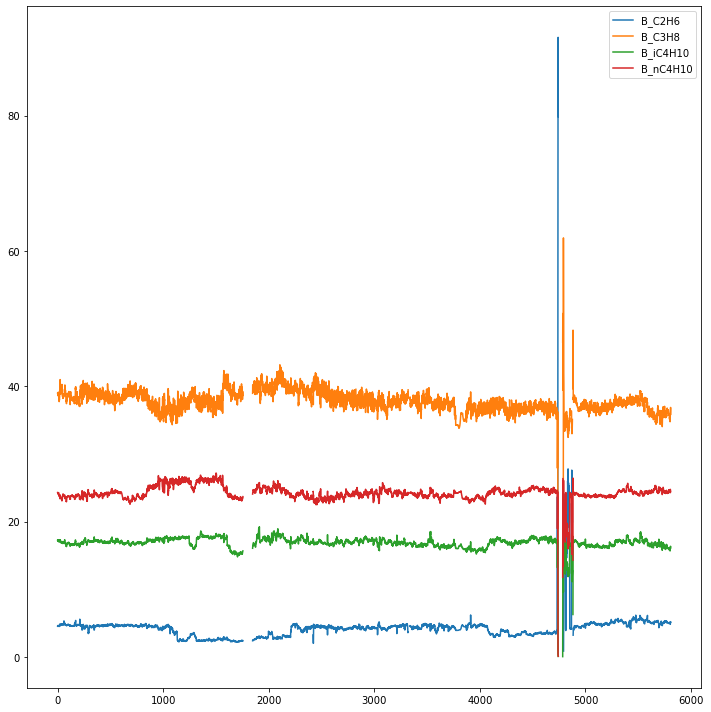

In [19]:
plt.rcParams["figure.figsize"] = (10,10)

train_target.plot()

# make room for tick labels
plt.tight_layout()


plt.show()

## Трансформация датасета

Попробуем оценить кажущийся отклик

In [20]:
train_features[['A_rate','B_rate']]

A_rate     B_rate
0     70.855017  71.982789
1     70.826582  71.965098
2     70.809637  71.867409
3     69.994748  71.839126
4     70.072762  71.336921
...         ...        ...
5803  72.009730  74.183355
5804  71.854180  74.213066
5805  71.783273  74.144367
5806  71.717743  74.320575
5807  71.730325  74.327170

[5808 rows x 2 columns]

In [21]:
derivatives_A = pd.DataFrame()
derivatives_B = pd.DataFrame()

derivatives_A['der_A_rate']=[]
derivatives_B ['der_B_rate']=[]

for i in range(train_features[['A_rate','B_rate']].shape[1]):
    for j in range(train_features[['A_rate','B_rate']].shape[0]-1):
        x = train_features[['A_rate','B_rate']].iloc[j,i]
        y = train_features[['A_rate','B_rate']].iloc[j+1,i]
        
        if i == 0:
            new_line = {'der_A_rate':(y-x)/30}
            derivatives_A = derivatives_A.append(new_line, ignore_index=True)
        else:
            new_line = {'der_B_rate':(y-x)/30}
            derivatives_B = derivatives_B.append(new_line, ignore_index=True)

In [22]:
derivatives = pd.concat([derivatives_A,derivatives_B.reset_index(drop=True)], axis=1)
derivatives

der_A_rate  der_B_rate
0      -0.000948   -0.000590
1      -0.000565   -0.003256
2      -0.027163   -0.000943
3       0.002600   -0.016740
4      -0.002479   -0.000636
...          ...         ...
5802   -0.008466    0.006174
5803   -0.005185    0.000990
5804   -0.002364   -0.002290
5805   -0.002184    0.005874
5806    0.000419    0.000220

[5807 rows x 2 columns]

In [23]:
# Сдвиг по времени 0
(derivatives['der_A_rate'] - derivatives['der_B_rate']).apply(np.abs).mean()

0.016707230655472926

In [24]:
# Сдвиг по времени 30 минут
x = derivatives['der_A_rate'][0:-1]
y = derivatives['der_B_rate'][1:]
z = pd.concat([x,y.reset_index(drop=True)], axis=1)
(z['der_A_rate'] - z['der_B_rate']).apply(np.abs).mean()

0.012438913385618582

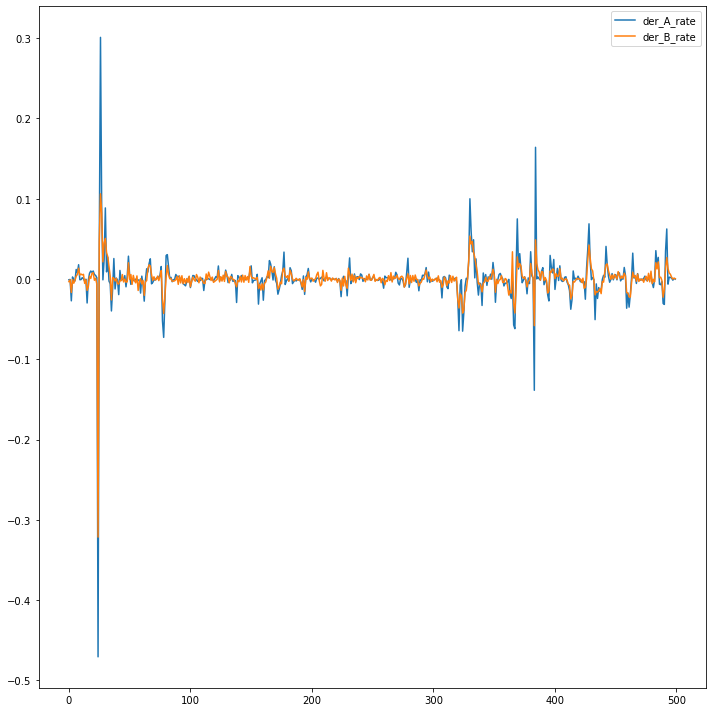

In [25]:
plt.rcParams["figure.figsize"] = (10,10)

z[0:500].plot()

# make room for tick labels
plt.tight_layout()

plt.show()

In [26]:
# Сдвиг по времени 60 минут
x = derivatives['der_A_rate'][0:-2]
y = derivatives['der_B_rate'][2:]
z = pd.concat([x,y.reset_index(drop=True)], axis=1)
(z['der_A_rate'] - z['der_B_rate']).apply(np.abs).mean()

0.01659637858206412

In [27]:
# Сдвиг по времени 90 минут
x = derivatives['der_A_rate'][0:-3]
y = derivatives['der_B_rate'][3:]
z = pd.concat([x,y.reset_index(drop=True)], axis=1)
(z['der_A_rate'] - z['der_B_rate']).apply(np.abs).mean()

0.0191065411244112

Кажущийся отклик 30 минут +- 15 минут

Теперь объединим признаки и таргеты на обучающей выборке. Заполним все пропуски предыдущими значениями. Строки в которых останутся NaN удалим

In [28]:
data = pd.concat([train_features,train_target.drop(['timestamp'], axis=1)], axis=1)
data.isnull().sum()

timestamp      0
A_rate         1
A_CH4        959
A_C2H6       959
A_C3H8       959
A_iC4H10     959
A_nC4H10     959
A_iC5H12     959
A_nC5H12     959
A_C6H14      959
B_rate       133
B_C2H6       184
B_C3H8       180
B_iC4H10     180
B_nC4H10     180
dtype: int64

In [29]:
data = data.ffill(axis = 0)
data.isnull().sum()

timestamp    0
A_rate       0
A_CH4        9
A_C2H6       9
A_C3H8       9
A_iC4H10     9
A_nC4H10     9
A_iC5H12     9
A_nC5H12     9
A_C6H14      9
B_rate       0
B_C2H6       0
B_C3H8       0
B_iC4H10     0
B_nC4H10     0
dtype: int64

In [30]:
NaNList = []
x = (data.isnull().sum(axis=1) > 0)
for i in range(x.shape[0]):
    if x[i] == True:
        NaNList.append(i)
data.drop(NaNList, axis=0, inplace=True)
data = data.reset_index(drop=True)

In [31]:
data

timestamp     A_rate     A_CH4    A_C2H6     A_C3H8  \
0     2020-01-01 04:30:00  71.055792  0.126244  5.242957  41.941480   
1     2020-01-01 05:00:00  71.029881  0.111301  4.632455  39.198330   
2     2020-01-01 05:30:00  71.008884  0.125176  4.730933  37.874656   
3     2020-01-01 06:00:00  71.060109  0.141546  5.214231  39.763493   
4     2020-01-01 06:30:00  71.067865  0.143911  5.440833  41.616510   
...                   ...        ...       ...       ...        ...   
5794  2020-04-30 21:30:00  72.009730  0.284151  4.936343  35.758852   
5795  2020-04-30 22:00:00  71.854180  0.282501  4.960453  35.877193   
5796  2020-04-30 22:30:00  71.783273  0.277686  5.013878  36.271557   
5797  2020-04-30 23:00:00  71.717743  0.271106  5.080144  36.616673   
5798  2020-04-30 23:30:00  71.730325  0.265635  5.069165  36.602453   

       A_iC4H10   A_nC4H10  A_iC5H12  A_nC5H12   A_C6H14     B_rate    B_C2H6  \
0     17.064213  23.205953  4.184848  4.062079  4.110170  71.389674  4.532649   
1     17.440245  24.331520  4.615703  4.545702  5.072316  71.792506  4.578543   
2     17.353362  24.567692  4.847911  4.818913  5.626975  71.939558  4.642879   
3     17.098163  23.758240  4.512244  4.429068  5.021207  72.124690  4.549837   
4     16.964787  23.121613  4.212636  4.088066  4.347822  72.278288  4.556611   
...         ...        ...       ...       ...       ...        ...       ...   
5794  16.473834  24.318968  6.069360  5.527463  6.577563  74.183355  4.816865   
5795  16.448487  24.074193  5.981357  5.407256  6.915378  74.213066  4.993286   
5796  16.500147  24.010123  5.829363  5.160329  6.884173  74.144367  5.101574   
5797  16.559533  24.008848  5.750492  5.017941  6.642076  74.320575  5.210675   
5798  16.649167  24.150503  5.752792  4.997528  6.459137  74.327170  5.136487   

         B_C3H8   B_iC4H10   B_nC4H10  
0     38.604149  17.238489  24.275393  
1     38.510623  17.193441  24.242152  
2     39.124029  17.301609  24.211492  
3     38.247333  17.118282  24.044074  
4     37.985776  17.038811  23.931490  
...         ...        ...        ...  
5794  35.539156  16.269938  24.770377  
5795  36.067750  16.317757  24.729847  
5796  36.275040  16.295460  24.629889  
5797  36.872917  16.336359  24.438236  
5798  35.860326  16.101509  24.426845  

[5799 rows x 15 columns]

In [32]:
monthList =[]
for i in data['timestamp']:
    monthList.append(int(str(i)[5:7]))

In [33]:
data['month'] = monthList

In [34]:
data

timestamp     A_rate     A_CH4    A_C2H6     A_C3H8  \
0     2020-01-01 04:30:00  71.055792  0.126244  5.242957  41.941480   
1     2020-01-01 05:00:00  71.029881  0.111301  4.632455  39.198330   
2     2020-01-01 05:30:00  71.008884  0.125176  4.730933  37.874656   
3     2020-01-01 06:00:00  71.060109  0.141546  5.214231  39.763493   
4     2020-01-01 06:30:00  71.067865  0.143911  5.440833  41.616510   
...                   ...        ...       ...       ...        ...   
5794  2020-04-30 21:30:00  72.009730  0.284151  4.936343  35.758852   
5795  2020-04-30 22:00:00  71.854180  0.282501  4.960453  35.877193   
5796  2020-04-30 22:30:00  71.783273  0.277686  5.013878  36.271557   
5797  2020-04-30 23:00:00  71.717743  0.271106  5.080144  36.616673   
5798  2020-04-30 23:30:00  71.730325  0.265635  5.069165  36.602453   

       A_iC4H10   A_nC4H10  A_iC5H12  A_nC5H12   A_C6H14     B_rate    B_C2H6  \
0     17.064213  23.205953  4.184848  4.062079  4.110170  71.389674  4.532649   
1     17.440245  24.331520  4.615703  4.545702  5.072316  71.792506  4.578543   
2     17.353362  24.567692  4.847911  4.818913  5.626975  71.939558  4.642879   
3     17.098163  23.758240  4.512244  4.429068  5.021207  72.124690  4.549837   
4     16.964787  23.121613  4.212636  4.088066  4.347822  72.278288  4.556611   
...         ...        ...       ...       ...       ...        ...       ...   
5794  16.473834  24.318968  6.069360  5.527463  6.577563  74.183355  4.816865   
5795  16.448487  24.074193  5.981357  5.407256  6.915378  74.213066  4.993286   
5796  16.500147  24.010123  5.829363  5.160329  6.884173  74.144367  5.101574   
5797  16.559533  24.008848  5.750492  5.017941  6.642076  74.320575  5.210675   
5798  16.649167  24.150503  5.752792  4.997528  6.459137  74.327170  5.136487   

         B_C3H8   B_iC4H10   B_nC4H10  month  
0     38.604149  17.238489  24.275393      1  
1     38.510623  17.193441  24.242152      1  
2     39.124029  17.301609  24.211492      1  
3     38.247333  17.118282  24.044074      1  
4     37.985776  17.038811  23.931490      1  
...         ...        ...        ...    ...  
5794  35.539156  16.269938  24.770377      4  
5795  36.067750  16.317757  24.729847      4  
5796  36.275040  16.295460  24.629889      4  
5797  36.872917  16.336359  24.438236      4  
5798  35.860326  16.101509  24.426845      4  

[5799 rows x 16 columns]

In [35]:
data.columns

Index(['timestamp', 'A_rate', 'A_CH4', 'A_C2H6', 'A_C3H8', 'A_iC4H10',
       'A_nC4H10', 'A_iC5H12', 'A_nC5H12', 'A_C6H14', 'B_rate', 'B_C2H6',
       'B_C3H8', 'B_iC4H10', 'B_nC4H10', 'month'],
      dtype='object')

In [36]:
#g = sns.PairGrid(data)
#g.map(sns.scatterplot)

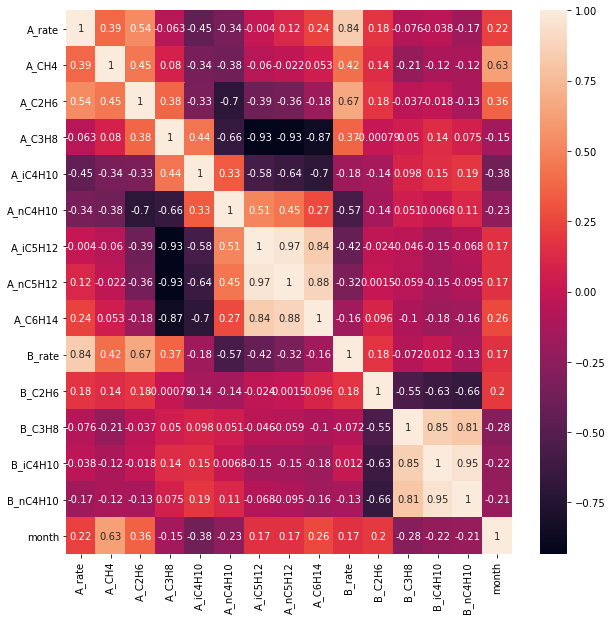

In [37]:
sns.heatmap(data.corr(), annot=True)

По [1] выпишем плотности сжиженных газов при 0 град Цельсия:

In [38]:
# кг/м3
ro_CH4 = 300.0 #Не нашел, указал из логических соображений
ro_C2H6 = 404.8
ro_C3H8 = 529.7
ro_iC4H10 = 581.0
ro_nC4H10 = 601.0
ro_iC5H12 = 639.2
ro_nC5H12 = 645.5
ro_C6H14 = 677.2

по [2] стр 65 выпишем динамическую вязкость сжиженных газов при 0 град Цельсия:

In [39]:
# Па*с
mu_CH4 = 10e-6 #Не нашел, указал из логических соображений
mu_C2H6 = 65e-6
mu_C3H8 = 140e-6
mu_iC4H10 = 225e-6
mu_nC4H10 = 215e-6
mu_iC5H12 = 285e-6
mu_nC5H12 = 295e-6
mu_C6H14 = 360e-6 #Не нашел, указал из логических соображений

по [3] выпишем молярные массы:

In [40]:
# кг/кмоль
M_CH4 = 16.04
M_C2H6 = 30.07
M_C3H8 = 44.1
M_iC4H10 = 58.12
M_nC4H10 = 58.12
M_iC5H12 = 72.15
M_nC5H12 = 72.15
M_C6H14 = 86.18

In [41]:
data['G_A_CH4'] = data['A_rate'] * data['A_CH4'] / 100
data['G_A_C2H6'] = data['A_rate'] * data['A_C2H6'] / 100
data['G_A_C3H8'] = data['A_rate'] * data['A_C3H8'] / 100
data['G_A_iC4H10'] = data['A_rate'] * data['A_iC4H10'] / 100
data['G_A_nC4H10'] = data['A_rate'] * data['A_nC4H10'] / 100
data['G_A_iC5H12'] = data['A_rate'] * data['A_iC5H12'] / 100
data['G_A_nC5H12'] = data['A_rate'] * data['A_nC5H12'] / 100
data['G_A_C6H14'] = data['A_rate'] * data['A_C6H14'] / 100

data['G_B_C2H6'] = data['B_rate'] * data['B_C2H6'] / 100
data['G_B_C3H8'] = data['B_rate'] * data['B_C3H8'] / 100
data['G_B_iC4H10'] = data['B_rate'] * data['B_iC4H10'] / 100
data['G_B_nC4H10'] = data['B_rate'] * data['B_nC4H10'] / 100

In [42]:
data['ro_mix_A'] = ((data['A_CH4'] / 100 / ro_CH4) + (data['A_C2H6'] / 100 / ro_C2H6) 
                  + (data['A_C3H8'] / 100 / ro_C3H8) + (data['A_iC4H10'] / 100 / ro_iC4H10) 
                  + (data['A_nC4H10'] / 100 / ro_nC4H10) + (data['A_iC5H12'] / 100 / ro_iC5H12)
                  + (data['A_nC5H12'] / 100 / ro_nC5H12) + (data['A_C6H14'] / 100 / ro_C6H14))**-1

In [43]:
data['mu_mix_A'] = (((data['A_CH4'] / 100) * (data['ro_mix_A'] / ro_CH4)) / mu_CH4 
                  + ((data['A_C2H6'] / 100) * (data['ro_mix_A'] / ro_C2H6)) / mu_C2H6 
                  + ((data['A_C3H8'] / 100) * (data['ro_mix_A'] / ro_C3H8)) / mu_C3H8
                  + ((data['A_iC4H10'] / 100) * (data['ro_mix_A'] / ro_iC4H10)) / mu_iC4H10
                  + ((data['A_nC4H10'] / 100) * (data['ro_mix_A'] / ro_nC4H10)) / mu_nC4H10
                  + ((data['A_iC5H12'] / 100) * (data['ro_mix_A'] / ro_iC5H12)) / mu_iC5H12
                  + ((data['A_nC5H12'] / 100) * (data['ro_mix_A'] / ro_nC5H12)) / mu_nC5H12
                  + ((data['A_C6H14'] / 100) * (data['ro_mix_A'] / ro_C6H14)) / mu_C6H14)**-1

In [44]:
data['w_A'] = (4*data['A_rate']*0.278)/(3.14*data['ro_mix_A']*0.16)
data['Re_A'] = (4*data['A_rate']*0.278)/(3.14*0.4*data['mu_mix_A'])

In [45]:
data['A_rate**2'] = data['A_rate']**2
data['sqrt_A_rate'] = data['A_rate'].apply(m.sqrt)
data['e**A_rate'] = data['A_rate'].apply(m.exp)
data['lg_A_rate'] = data['A_rate'].apply(m.log10)
data['ln_A_rate'] = data['A_rate'].apply(m.log)

data['B_rate**2'] = data['B_rate']**2
data['sqrt_B_rate'] = data['B_rate'].apply(m.sqrt)
data['e**B_rate'] = data['B_rate'].apply(m.exp)
#data['lg_B_rate'] = data['B_rate'].apply(m.log10)
#data['ln_B_rate'] = data['B_rate'].apply(m.log)

data['Re_A**2'] = data['Re_A']**2
data['sqrt_Re_A'] = data['Re_A'].apply(m.sqrt)
#data['e**Re_A'] = data['Re_A'].apply(m.exp)
data['lg_Re_A'] = data['Re_A'].apply(m.log10)
data['ln_Re_A'] = data['Re_A'].apply(m.log)

In [46]:
data.head()

timestamp     A_rate     A_CH4    A_C2H6     A_C3H8   A_iC4H10  \
0  2020-01-01 04:30:00  71.055792  0.126244  5.242957  41.941480  17.064213   
1  2020-01-01 05:00:00  71.029881  0.111301  4.632455  39.198330  17.440245   
2  2020-01-01 05:30:00  71.008884  0.125176  4.730933  37.874656  17.353362   
3  2020-01-01 06:00:00  71.060109  0.141546  5.214231  39.763493  17.098163   
4  2020-01-01 06:30:00  71.067865  0.143911  5.440833  41.616510  16.964787   

    A_nC4H10  A_iC5H12  A_nC5H12   A_C6H14     B_rate    B_C2H6     B_C3H8  \
0  23.205953  4.184848  4.062079  4.110170  71.389674  4.532649  38.604149   
1  24.331520  4.615703  4.545702  5.072316  71.792506  4.578543  38.510623   
2  24.567692  4.847911  4.818913  5.626975  71.939558  4.642879  39.124029   
3  23.758240  4.512244  4.429068  5.021207  72.124690  4.549837  38.247333   
4  23.121613  4.212636  4.088066  4.347822  72.278288  4.556611  37.985776   

    B_iC4H10   B_nC4H10  month   G_A_CH4  G_A_C2H6   G_A_C3H8  G_A_iC4H10  \
0  17.238489  24.275393      1  0.089704  3.725424  29.801851   12.125112   
1  17.193441  24.242152      1  0.079057  3.290427  27.842527   12.387785   
2  17.301609  24.211492      1  0.088886  3.359382  26.894371   12.322429   
3  17.118282  24.044074      1  0.100583  3.705238  28.255982   12.149973   
4  17.038811  23.931490      1  0.102275  3.866684  29.575965   12.056512   

   G_A_nC4H10  G_A_iC5H12  G_A_nC5H12  G_A_C6H14  G_B_C2H6   G_B_C3H8  \
0   16.489174    2.973577    2.886343   2.920514  3.235844  27.559376   
1   17.282650    3.278528    3.228807   3.602860  3.287050  27.647742   
2   17.445244    3.442448    3.421856   3.995652  3.340066  28.145653   
3   16.882631    3.206406    3.147301   3.568075  3.281556  27.585770   
4   16.432037    2.993830    2.905301   3.089904  3.293440  27.455469   

   G_B_iC4H10  G_B_nC4H10    ro_mix_A  mu_mix_A       w_A           Re_A  \
0   12.306501   17.330124  557.275650  0.000152  0.282218  413051.697732   
1   12.343602   17.404049  561.571098  0.000157  0.279957  400285.363153   
2   12.446701   17.417641  562.709910  0.000157  0.279308  399799.094868   
3   12.346508   17.341714  559.546588  0.000153  0.281090  410055.101480   
4   12.315361   17.297271  557.097386  0.000151  0.282356  416101.617450   

     A_rate**2  sqrt_A_rate     e**A_rate  lg_A_rate  ln_A_rate    B_rate**2  \
0  5048.925626     8.429460  7.230004e+30   1.851599   4.263465  5096.485564   
1  5045.244022     8.427923  7.045072e+30   1.851441   4.263101  5154.163907   
2  5042.261673     8.426677  6.898691e+30   1.851313   4.262805  5175.300044   
3  5049.539078     8.429716  7.261280e+30   1.851626   4.263526  5201.970854   
4  5050.641380     8.430176  7.317815e+30   1.851673   4.263635  5224.150961   

   sqrt_B_rate     e**B_rate       Re_A**2   sqrt_Re_A   lg_Re_A    ln_Re_A  
0     8.449241  1.009582e+31  1.706117e+11  642.690982  5.616004  12.931328  
1     8.473046  1.510390e+31  1.602284e+11  632.681091  5.602370  12.899933  
2     8.481719  1.749658e+31  1.598393e+11  632.296683  5.601842  12.898717  
3     8.492626  2.105497e+31  1.681452e+11  640.355449  5.612842  12.924047  
4     8.501664  2.455058e+31  1.731406e+11  645.059391  5.619199  12.938685

In [47]:
Ct_A = pd.DataFrame({'Ct_A_C2H6':[np.nan],'Ct_A_C3H8':[np.nan],'Ct_A_iC4H10':[np.nan],
                     'Ct_A_nC4H10':[np.nan]})

Cx_A = pd.DataFrame({'Cx_A_C2H6':[np.nan],'Cx_A_C3H8':[np.nan],'Cx_A_iC4H10':[np.nan],
                     'Cx_A_nC4H10':[np.nan]})

G = data[['G_A_C2H6', 'G_A_C3H8', 'G_A_iC4H10', 'G_A_nC4H10',
          'G_B_C2H6', 'G_B_C3H8','G_B_iC4H10', 'G_B_nC4H10']]

In [48]:
for i in range(G.shape[0]-1):
    new_line = {}
    for j in range(G.shape[1]-4):
        x = G.iloc[i,j]
        y = G.iloc[i+1,j]
        new_line.update({Ct_A .columns[j]:(y-x)})
    Ct_A = Ct_A.append(new_line, ignore_index=True)

In [49]:
G.head()

G_A_C2H6   G_A_C3H8  G_A_iC4H10  G_A_nC4H10  G_B_C2H6   G_B_C3H8  \
0  3.725424  29.801851   12.125112   16.489174  3.235844  27.559376   
1  3.290427  27.842527   12.387785   17.282650  3.287050  27.647742   
2  3.359382  26.894371   12.322429   17.445244  3.340066  28.145653   
3  3.705238  28.255982   12.149973   16.882631  3.281556  27.585770   
4  3.866684  29.575965   12.056512   16.432037  3.293440  27.455469   

   G_B_iC4H10  G_B_nC4H10  
0   12.306501   17.330124  
1   12.343602   17.404049  
2   12.446701   17.417641  
3   12.346508   17.341714  
4   12.315361   17.297271

In [50]:
Ct_A 

Ct_A_C2H6  Ct_A_C3H8  Ct_A_iC4H10  Ct_A_nC4H10
0           NaN        NaN          NaN          NaN
1     -0.434997  -1.959324     0.262673     0.793476
2      0.068955  -0.948157    -0.065357     0.162594
3      0.345856   1.361611    -0.172455    -0.562613
4      0.161446   1.319983    -0.093462    -0.450594
...         ...        ...          ...          ...
5794  -0.096809  -0.765812    -0.087026    -0.011302
5795   0.009645   0.029410    -0.043838    -0.213709
5796   0.034833   0.257647     0.025420    -0.063062
5797   0.044239   0.223741     0.031778    -0.016648
5798  -0.007236  -0.005593     0.066378     0.104630

[5799 rows x 4 columns]

In [51]:
for i in range(G.shape[0]-1):
    new_line = {}
    for j in range(G.shape[1]-4):
        x = G.iloc[i,j]
        y = G.iloc[i,j+4]
        new_line.update({Cx_A .columns[j]:(y-x)})
    Cx_A = Cx_A.append(new_line, ignore_index=True)

In [52]:
G.head()

G_A_C2H6   G_A_C3H8  G_A_iC4H10  G_A_nC4H10  G_B_C2H6   G_B_C3H8  \
0  3.725424  29.801851   12.125112   16.489174  3.235844  27.559376   
1  3.290427  27.842527   12.387785   17.282650  3.287050  27.647742   
2  3.359382  26.894371   12.322429   17.445244  3.340066  28.145653   
3  3.705238  28.255982   12.149973   16.882631  3.281556  27.585770   
4  3.866684  29.575965   12.056512   16.432037  3.293440  27.455469   

   G_B_iC4H10  G_B_nC4H10  
0   12.306501   17.330124  
1   12.343602   17.404049  
2   12.446701   17.417641  
3   12.346508   17.341714  
4   12.315361   17.297271

In [53]:
Cx_A

Cx_A_C2H6  Cx_A_C3H8  Cx_A_iC4H10  Cx_A_nC4H10
0           NaN        NaN          NaN          NaN
1     -0.489581  -2.242475     0.181389     0.840950
2     -0.003377  -0.194786    -0.044183     0.121399
3     -0.019316   1.251283     0.124272    -0.027603
4     -0.423683  -0.670212     0.196535     0.459082
...         ...        ...          ...          ...
5794   0.046943  -0.516086    -0.252523     0.529955
5795   0.018665   0.614285     0.206822     0.863474
5796   0.141378   0.987720     0.290982     1.054463
5797   0.183404   0.858988     0.237820     1.026423
5798   0.229239   1.143513     0.265152     0.944034

[5799 rows x 4 columns]

In [54]:
w = pd.DataFrame({'w_prev':[np.nan]})
j = pd.DataFrame({'w_prev':data['w_A']})
w = pd.concat([w,j], axis=0)
w = w.reset_index(drop=True)
w.drop(5799, axis=0, inplace=True)
w = w.reset_index(drop=True)
w

w_prev
0          NaN
1     0.282218
2     0.279957
3     0.279308
4     0.281090
...        ...
5794  0.284241
5795  0.282492
5796  0.281884
5797  0.281886
5798  0.281933

[5799 rows x 1 columns]

In [55]:
x = data
y = pd.concat([Cx_A,Ct_A,w], axis=1)
data = pd.concat([data,y], axis=1)

In [56]:
data.head()

timestamp     A_rate     A_CH4    A_C2H6     A_C3H8   A_iC4H10  \
0  2020-01-01 04:30:00  71.055792  0.126244  5.242957  41.941480  17.064213   
1  2020-01-01 05:00:00  71.029881  0.111301  4.632455  39.198330  17.440245   
2  2020-01-01 05:30:00  71.008884  0.125176  4.730933  37.874656  17.353362   
3  2020-01-01 06:00:00  71.060109  0.141546  5.214231  39.763493  17.098163   
4  2020-01-01 06:30:00  71.067865  0.143911  5.440833  41.616510  16.964787   

    A_nC4H10  A_iC5H12  A_nC5H12   A_C6H14     B_rate    B_C2H6     B_C3H8  \
0  23.205953  4.184848  4.062079  4.110170  71.389674  4.532649  38.604149   
1  24.331520  4.615703  4.545702  5.072316  71.792506  4.578543  38.510623   
2  24.567692  4.847911  4.818913  5.626975  71.939558  4.642879  39.124029   
3  23.758240  4.512244  4.429068  5.021207  72.124690  4.549837  38.247333   
4  23.121613  4.212636  4.088066  4.347822  72.278288  4.556611  37.985776   

    B_iC4H10   B_nC4H10  month   G_A_CH4  G_A_C2H6   G_A_C3H8  G_A_iC4H10  \
0  17.238489  24.275393      1  0.089704  3.725424  29.801851   12.125112   
1  17.193441  24.242152      1  0.079057  3.290427  27.842527   12.387785   
2  17.301609  24.211492      1  0.088886  3.359382  26.894371   12.322429   
3  17.118282  24.044074      1  0.100583  3.705238  28.255982   12.149973   
4  17.038811  23.931490      1  0.102275  3.866684  29.575965   12.056512   

   G_A_nC4H10  G_A_iC5H12  G_A_nC5H12  G_A_C6H14  G_B_C2H6   G_B_C3H8  \
0   16.489174    2.973577    2.886343   2.920514  3.235844  27.559376   
1   17.282650    3.278528    3.228807   3.602860  3.287050  27.647742   
2   17.445244    3.442448    3.421856   3.995652  3.340066  28.145653   
3   16.882631    3.206406    3.147301   3.568075  3.281556  27.585770   
4   16.432037    2.993830    2.905301   3.089904  3.293440  27.455469   

   G_B_iC4H10  G_B_nC4H10    ro_mix_A  mu_mix_A       w_A           Re_A  \
0   12.306501   17.330124  557.275650  0.000152  0.282218  413051.697732   
1   12.343602   17.404049  561.571098  0.000157  0.279957  400285.363153   
2   12.446701   17.417641  562.709910  0.000157  0.279308  399799.094868   
3   12.346508   17.341714  559.546588  0.000153  0.281090  410055.101480   
4   12.315361   17.297271  557.097386  0.000151  0.282356  416101.617450   

     A_rate**2  sqrt_A_rate     e**A_rate  lg_A_rate  ln_A_rate    B_rate**2  \
0  5048.925626     8.429460  7.230004e+30   1.851599   4.263465  5096.485564   
1  5045.244022     8.427923  7.045072e+30   1.851441   4.263101  5154.163907   
2  5042.261673     8.426677  6.898691e+30   1.851313   4.262805  5175.300044   
3  5049.539078     8.429716  7.261280e+30   1.851626   4.263526  5201.970854   
4  5050.641380     8.430176  7.317815e+30   1.851673   4.263635  5224.150961   

   sqrt_B_rate     e**B_rate       Re_A**2   sqrt_Re_A   lg_Re_A    ln_Re_A  \
0     8.449241  1.009582e+31  1.706117e+11  642.690982  5.616004  12.931328   
1     8.473046  1.510390e+31  1.602284e+11  632.681091  5.602370  12.899933   
2     8.481719  1.749658e+31  1.598393e+11  632.296683  5.601842  12.898717   
3     8.492626  2.105497e+31  1.681452e+11  640.355449  5.612842  12.924047   
4     8.501664  2.455058e+31  1.731406e+11  645.059391  5.619199  12.938685   

   Cx_A_C2H6  Cx_A_C3H8  Cx_A_iC4H10  Cx_A_nC4H10  Ct_A_C2H6  Ct_A_C3H8  \
0        NaN        NaN          NaN          NaN        NaN        NaN   
1  -0.489581  -2.242475     0.181389     0.840950  -0.434997  -1.959324   
2  -0.003377  -0.194786    -0.044183     0.121399   0.068955  -0.948157   
3  -0.019316   1.251283     0.124272    -0.027603   0.345856   1.361611   
4  -0.423683  -0.670212     0.196535     0.459082   0.161446   1.319983   

   Ct_A_iC4H10  Ct_A_nC4H10    w_prev  
0          NaN          NaN       NaN  
1     0.262673     0.793476  0.282218  
2    -0.065357     0.162594  0.279957  
3    -0.172455    -0.562613  0.279308  
4    -0.093462    -0.450594  0.281090

In [57]:
data.drop(0, axis=0, inplace=True)
data = data.reset_index(drop=True)

In [58]:
data.head()

timestamp     A_rate     A_CH4    A_C2H6     A_C3H8   A_iC4H10  \
0  2020-01-01 05:00:00  71.029881  0.111301  4.632455  39.198330  17.440245   
1  2020-01-01 05:30:00  71.008884  0.125176  4.730933  37.874656  17.353362   
2  2020-01-01 06:00:00  71.060109  0.141546  5.214231  39.763493  17.098163   
3  2020-01-01 06:30:00  71.067865  0.143911  5.440833  41.616510  16.964787   
4  2020-01-01 07:00:00  70.980866  0.128208  5.098310  41.394830  17.190317   

    A_nC4H10  A_iC5H12  A_nC5H12   A_C6H14     B_rate    B_C2H6     B_C3H8  \
0  24.331520  4.615703  4.545702  5.072316  71.792506  4.578543  38.510623   
1  24.567692  4.847911  4.818913  5.626975  71.939558  4.642879  39.124029   
2  23.758240  4.512244  4.429068  5.021207  72.124690  4.549837  38.247333   
3  23.121613  4.212636  4.088066  4.347822  72.278288  4.556611  37.985776   
4  23.393417  4.245694  4.132245  4.359903  72.454090  4.540633  37.742741   

    B_iC4H10   B_nC4H10  month   G_A_CH4  G_A_C2H6   G_A_C3H8  G_A_iC4H10  \
0  17.193441  24.242152      1  0.079057  3.290427  27.842527   12.387785   
1  17.301609  24.211492      1  0.088886  3.359382  26.894371   12.322429   
2  17.118282  24.044074      1  0.100583  3.705238  28.255982   12.149973   
3  17.038811  23.931490      1  0.102275  3.866684  29.575965   12.056512   
4  16.951270  23.796385      1  0.091003  3.618825  29.382409   12.201836   

   G_A_nC4H10  G_A_iC5H12  G_A_nC5H12  G_A_C6H14  G_B_C2H6   G_B_C3H8  \
0   17.282650    3.278528    3.228807   3.602860  3.287050  27.647742   
1   17.445244    3.442448    3.421856   3.995652  3.340066  28.145653   
2   16.882631    3.206406    3.147301   3.568075  3.281556  27.585770   
3   16.432037    2.993830    2.905301   3.089904  3.293440  27.455469   
4   16.604850    3.013631    2.933103   3.094697  3.289875  27.346160   

   G_B_iC4H10  G_B_nC4H10    ro_mix_A  mu_mix_A       w_A           Re_A  \
0   12.343602   17.404049  561.571098  0.000157  0.279957  400285.363153   
1   12.446701   17.417641  562.709910  0.000157  0.279308  399799.094868   
2   12.346508   17.341714  559.546588  0.000153  0.281090  410055.101480   
3   12.315361   17.297271  557.097386  0.000151  0.282356  416101.617450   
4   12.281888   17.241454  558.150167  0.000153  0.281479  410432.313574   

     A_rate**2  sqrt_A_rate     e**A_rate  lg_A_rate  ln_A_rate    B_rate**2  \
0  5045.244022     8.427923  7.045072e+30   1.851441   4.263101  5154.163907   
1  5042.261673     8.426677  6.898691e+30   1.851313   4.262805  5175.300044   
2  5049.539078     8.429716  7.261280e+30   1.851626   4.263526  5201.970854   
3  5050.641380     8.430176  7.317815e+30   1.851673   4.263635  5224.150961   
4  5038.283284     8.425014  6.708080e+30   1.851141   4.262410  5249.595211   

   sqrt_B_rate     e**B_rate       Re_A**2   sqrt_Re_A   lg_Re_A    ln_Re_A  \
0     8.473046  1.510390e+31  1.602284e+11  632.681091  5.602370  12.899933   
1     8.481719  1.749658e+31  1.598393e+11  632.296683  5.601842  12.898717   
2     8.492626  2.105497e+31  1.681452e+11  640.355449  5.612842  12.924047   
3     8.501664  2.455058e+31  1.731406e+11  645.059391  5.619199  12.938685   
4     8.511997  2.926925e+31  1.684547e+11  640.649915  5.613242  12.924966   

   Cx_A_C2H6  Cx_A_C3H8  Cx_A_iC4H10  Cx_A_nC4H10  Ct_A_C2H6  Ct_A_C3H8  \
0  -0.489581  -2.242475     0.181389     0.840950  -0.434997  -1.959324   
1  -0.003377  -0.194786    -0.044183     0.121399   0.068955  -0.948157   
2  -0.019316   1.251283     0.124272    -0.027603   0.345856   1.361611   
3  -0.423683  -0.670212     0.196535     0.459082   0.161446   1.319983   
4  -0.573244  -2.120496     0.258850     0.865234  -0.247859  -0.193556   

   Ct_A_iC4H10  Ct_A_nC4H10    w_prev  
0     0.262673     0.793476  0.282218  
1    -0.065357     0.162594  0.279957  
2    -0.172455    -0.562613  0.279308  
3    -0.093462    -0.450594  0.281090  
4     0.145324     0.172813  0.282356

In [59]:
data['Cx_A_C2H6**2'] = data['Cx_A_C2H6']**2
data['Cx_A_C3H8**2'] = data['Cx_A_C3H8']**2
data['Cx_A_iC4H10**2'] = data['Cx_A_iC4H10']**2
data['Cx_A_nC4H10**2'] = data['Cx_A_nC4H10']**2

data['E_C2H6'] = (data['Ct_A_C2H6'] + data['w_prev'] * data['Cx_A_C2H6'])/ data['Cx_A_C2H6**2']
data['E_C3H8'] = (data['Ct_A_C3H8'] + data['w_prev'] * data['Cx_A_C3H8'])/ data['Cx_A_C3H8**2']
data['E_iC4H10'] = (data['Ct_A_iC4H10'] + data['w_prev'] * data['Cx_A_iC4H10'])/ data['Cx_A_iC4H10**2']
data['E_nC4H10'] = (data['Ct_A_nC4H10'] + data['w_prev'] * data['Cx_A_nC4H10'])/ data['Cx_A_nC4H10**2']

data['Pe_ef_C2H6'] = data['w_prev'] / data['E_C2H6']
data['Pe_ef_C3H8'] = data['w_prev'] / data['E_C3H8']
data['Pe_ef_iC4H10'] = data['w_prev'] / data['E_iC4H10']
data['Pe_ef_nC4H10'] = data['w_prev'] / data['E_nC4H10']

In [60]:
data['Pe_ef_C2H6**2'] = data['Pe_ef_C2H6']**2
#data['sqrt_Pe_ef_C2H6'] = data['Pe_ef_C2H6'].apply(m.sqrt)
#data['e**Pe_ef_C2H6'] = data['Pe_ef_C2H6'].apply(m.exp)
#data['lg_Pe_ef_C2H6'] = data['Pe_ef_C2H6'].apply(m.log10)
#data['ln_Pe_ef_C2H6'] = data['Pe_ef_C2H6'].apply(m.log)

data['Pe_ef_C3H8**2'] = data['Pe_ef_C3H8']**2
#data['sqrt_Pe_ef_C3H8'] = data['Pe_ef_C3H8'].apply(m.sqrt)
#data['e**Pe_ef_C3H8'] = data['Pe_ef_C3H8'].apply(m.exp)
#data['lg_Pe_ef_C3H8'] = data['Pe_ef_C3H8'].apply(m.log10)
#data['ln_Pe_ef_C3H8'] = data['Pe_ef_C3H8'].apply(m.log)

data['Pe_ef_iC4H10**2'] = data['Pe_ef_iC4H10']**2
#data['sqrt_Pe_ef_iC4H10'] = data['Pe_ef_iC4H10'].apply(m.sqrt)
#data['e**Pe_ef_iC4H10'] = data['Pe_ef_iC4H10'].apply(m.exp)
#data['lg_Pe_ef_iC4H10'] = data['Pe_ef_iC4H10'].apply(m.log10)
#data['ln_Pe_ef_iC4H10'] = data['Pe_ef_iC4H10'].apply(m.log)

data['Pe_ef_iC4H10**2'] = data['Pe_ef_iC4H10']**2
#data['sqrt_Pe_ef_iC4H10'] = data['Pe_ef_iC4H10'].apply(m.sqrt)
#data['e**Pe_ef_iC4H10'] = data['Pe_ef_iC4H10'].apply(m.exp)
#data['lg_Pe_ef_iC4H10e'] = data['Pe_ef_iC4H10'].apply(m.log10)
#data['ln_Pe_ef_iC4H10'] = data['Pe_ef_iC4H10'].apply(m.log)

In [61]:
data.head()

timestamp     A_rate     A_CH4    A_C2H6     A_C3H8   A_iC4H10  \
0  2020-01-01 05:00:00  71.029881  0.111301  4.632455  39.198330  17.440245   
1  2020-01-01 05:30:00  71.008884  0.125176  4.730933  37.874656  17.353362   
2  2020-01-01 06:00:00  71.060109  0.141546  5.214231  39.763493  17.098163   
3  2020-01-01 06:30:00  71.067865  0.143911  5.440833  41.616510  16.964787   
4  2020-01-01 07:00:00  70.980866  0.128208  5.098310  41.394830  17.190317   

    A_nC4H10  A_iC5H12  A_nC5H12   A_C6H14     B_rate    B_C2H6     B_C3H8  \
0  24.331520  4.615703  4.545702  5.072316  71.792506  4.578543  38.510623   
1  24.567692  4.847911  4.818913  5.626975  71.939558  4.642879  39.124029   
2  23.758240  4.512244  4.429068  5.021207  72.124690  4.549837  38.247333   
3  23.121613  4.212636  4.088066  4.347822  72.278288  4.556611  37.985776   
4  23.393417  4.245694  4.132245  4.359903  72.454090  4.540633  37.742741   

    B_iC4H10   B_nC4H10  month   G_A_CH4  G_A_C2H6   G_A_C3H8  G_A_iC4H10  \
0  17.193441  24.242152      1  0.079057  3.290427  27.842527   12.387785   
1  17.301609  24.211492      1  0.088886  3.359382  26.894371   12.322429   
2  17.118282  24.044074      1  0.100583  3.705238  28.255982   12.149973   
3  17.038811  23.931490      1  0.102275  3.866684  29.575965   12.056512   
4  16.951270  23.796385      1  0.091003  3.618825  29.382409   12.201836   

   G_A_nC4H10  G_A_iC5H12  G_A_nC5H12  G_A_C6H14  G_B_C2H6   G_B_C3H8  \
0   17.282650    3.278528    3.228807   3.602860  3.287050  27.647742   
1   17.445244    3.442448    3.421856   3.995652  3.340066  28.145653   
2   16.882631    3.206406    3.147301   3.568075  3.281556  27.585770   
3   16.432037    2.993830    2.905301   3.089904  3.293440  27.455469   
4   16.604850    3.013631    2.933103   3.094697  3.289875  27.346160   

   G_B_iC4H10  G_B_nC4H10    ro_mix_A  mu_mix_A       w_A           Re_A  \
0   12.343602   17.404049  561.571098  0.000157  0.279957  400285.363153   
1   12.446701   17.417641  562.709910  0.000157  0.279308  399799.094868   
2   12.346508   17.341714  559.546588  0.000153  0.281090  410055.101480   
3   12.315361   17.297271  557.097386  0.000151  0.282356  416101.617450   
4   12.281888   17.241454  558.150167  0.000153  0.281479  410432.313574   

     A_rate**2  sqrt_A_rate     e**A_rate  lg_A_rate  ln_A_rate    B_rate**2  \
0  5045.244022     8.427923  7.045072e+30   1.851441   4.263101  5154.163907   
1  5042.261673     8.426677  6.898691e+30   1.851313   4.262805  5175.300044   
2  5049.539078     8.429716  7.261280e+30   1.851626   4.263526  5201.970854   
3  5050.641380     8.430176  7.317815e+30   1.851673   4.263635  5224.150961   
4  5038.283284     8.425014  6.708080e+30   1.851141   4.262410  5249.595211   

   sqrt_B_rate     e**B_rate       Re_A**2   sqrt_Re_A   lg_Re_A    ln_Re_A  \
0     8.473046  1.510390e+31  1.602284e+11  632.681091  5.602370  12.899933   
1     8.481719  1.749658e+31  1.598393e+11  632.296683  5.601842  12.898717   
2     8.492626  2.105497e+31  1.681452e+11  640.355449  5.612842  12.924047   
3     8.501664  2.455058e+31  1.731406e+11  645.059391  5.619199  12.938685   
4     8.511997  2.926925e+31  1.684547e+11  640.649915  5.613242  12.924966   

   Cx_A_C2H6  Cx_A_C3H8  Cx_A_iC4H10  Cx_A_nC4H10  Ct_A_C2H6  Ct_A_C3H8  \
0  -0.489581  -2.242475     0.181389     0.840950  -0.434997  -1.959324   
1  -0.003377  -0.194786    -0.044183     0.121399   0.068955  -0.948157   
2  -0.019316   1.251283     0.124272    -0.027603   0.345856   1.361611   
3  -0.423683  -0.670212     0.196535     0.459082   0.161446   1.319983   
4  -0.573244  -2.120496     0.258850     0.865234  -0.247859  -0.193556   

   Ct_A_iC4H10  Ct_A_nC4H10    w_prev  Cx_A_C2H6**2  Cx_A_C3H8**2  \
0     0.262673     0.793476  0.282218      0.239689      5.028694   
1    -0.065357     0.162594  0.279957      0.000011      0.037941   
2    -0.172455    -0.562613  0.279308      0.000373      1.565708   
3    -0.093462    -0.450594

In [62]:
data.columns

Index(['timestamp', 'A_rate', 'A_CH4', 'A_C2H6', 'A_C3H8', 'A_iC4H10',
       'A_nC4H10', 'A_iC5H12', 'A_nC5H12', 'A_C6H14', 'B_rate', 'B_C2H6',
       'B_C3H8', 'B_iC4H10', 'B_nC4H10', 'month', 'G_A_CH4', 'G_A_C2H6',
       'G_A_C3H8', 'G_A_iC4H10', 'G_A_nC4H10', 'G_A_iC5H12', 'G_A_nC5H12',
       'G_A_C6H14', 'G_B_C2H6', 'G_B_C3H8', 'G_B_iC4H10', 'G_B_nC4H10',
       'ro_mix_A', 'mu_mix_A', 'w_A', 'Re_A', 'A_rate**2', 'sqrt_A_rate',
       'e**A_rate', 'lg_A_rate', 'ln_A_rate', 'B_rate**2', 'sqrt_B_rate',
       'e**B_rate', 'Re_A**2', 'sqrt_Re_A', 'lg_Re_A', 'ln_Re_A', 'Cx_A_C2H6',
       'Cx_A_C3H8', 'Cx_A_iC4H10', 'Cx_A_nC4H10', 'Ct_A_C2H6', 'Ct_A_C3H8',
       'Ct_A_iC4H10', 'Ct_A_nC4H10', 'w_prev', 'Cx_A_C2H6**2', 'Cx_A_C3H8**2',
       'Cx_A_iC4H10**2', 'Cx_A_nC4H10**2', 'E_C2H6', 'E_C3H8', 'E_iC4H10',
       'E_nC4H10', 'Pe_ef_C2H6', 'Pe_ef_C3H8', 'Pe_ef_iC4H10', 'Pe_ef_nC4H10',
       'Pe_ef_C2H6**2', 'Pe_ef_C3H8**2', 'Pe_ef_iC4H10**2'],
      dtype='object')

In [63]:
x = data.drop(labels=['timestamp','B_C2H6','B_C3H8', 'B_iC4H10','B_nC4H10',
                      'G_B_C2H6','G_B_C3H8', 'G_B_iC4H10','G_B_nC4H10'], axis=1)
y = data[['B_C2H6','B_C3H8', 'B_iC4H10','B_nC4H10', 
                'G_B_C2H6','G_B_C3H8', 'G_B_iC4H10','G_B_nC4H10']]

In [64]:
#g = sns.PairGrid(data)
#g.map(sns.scatterplot)

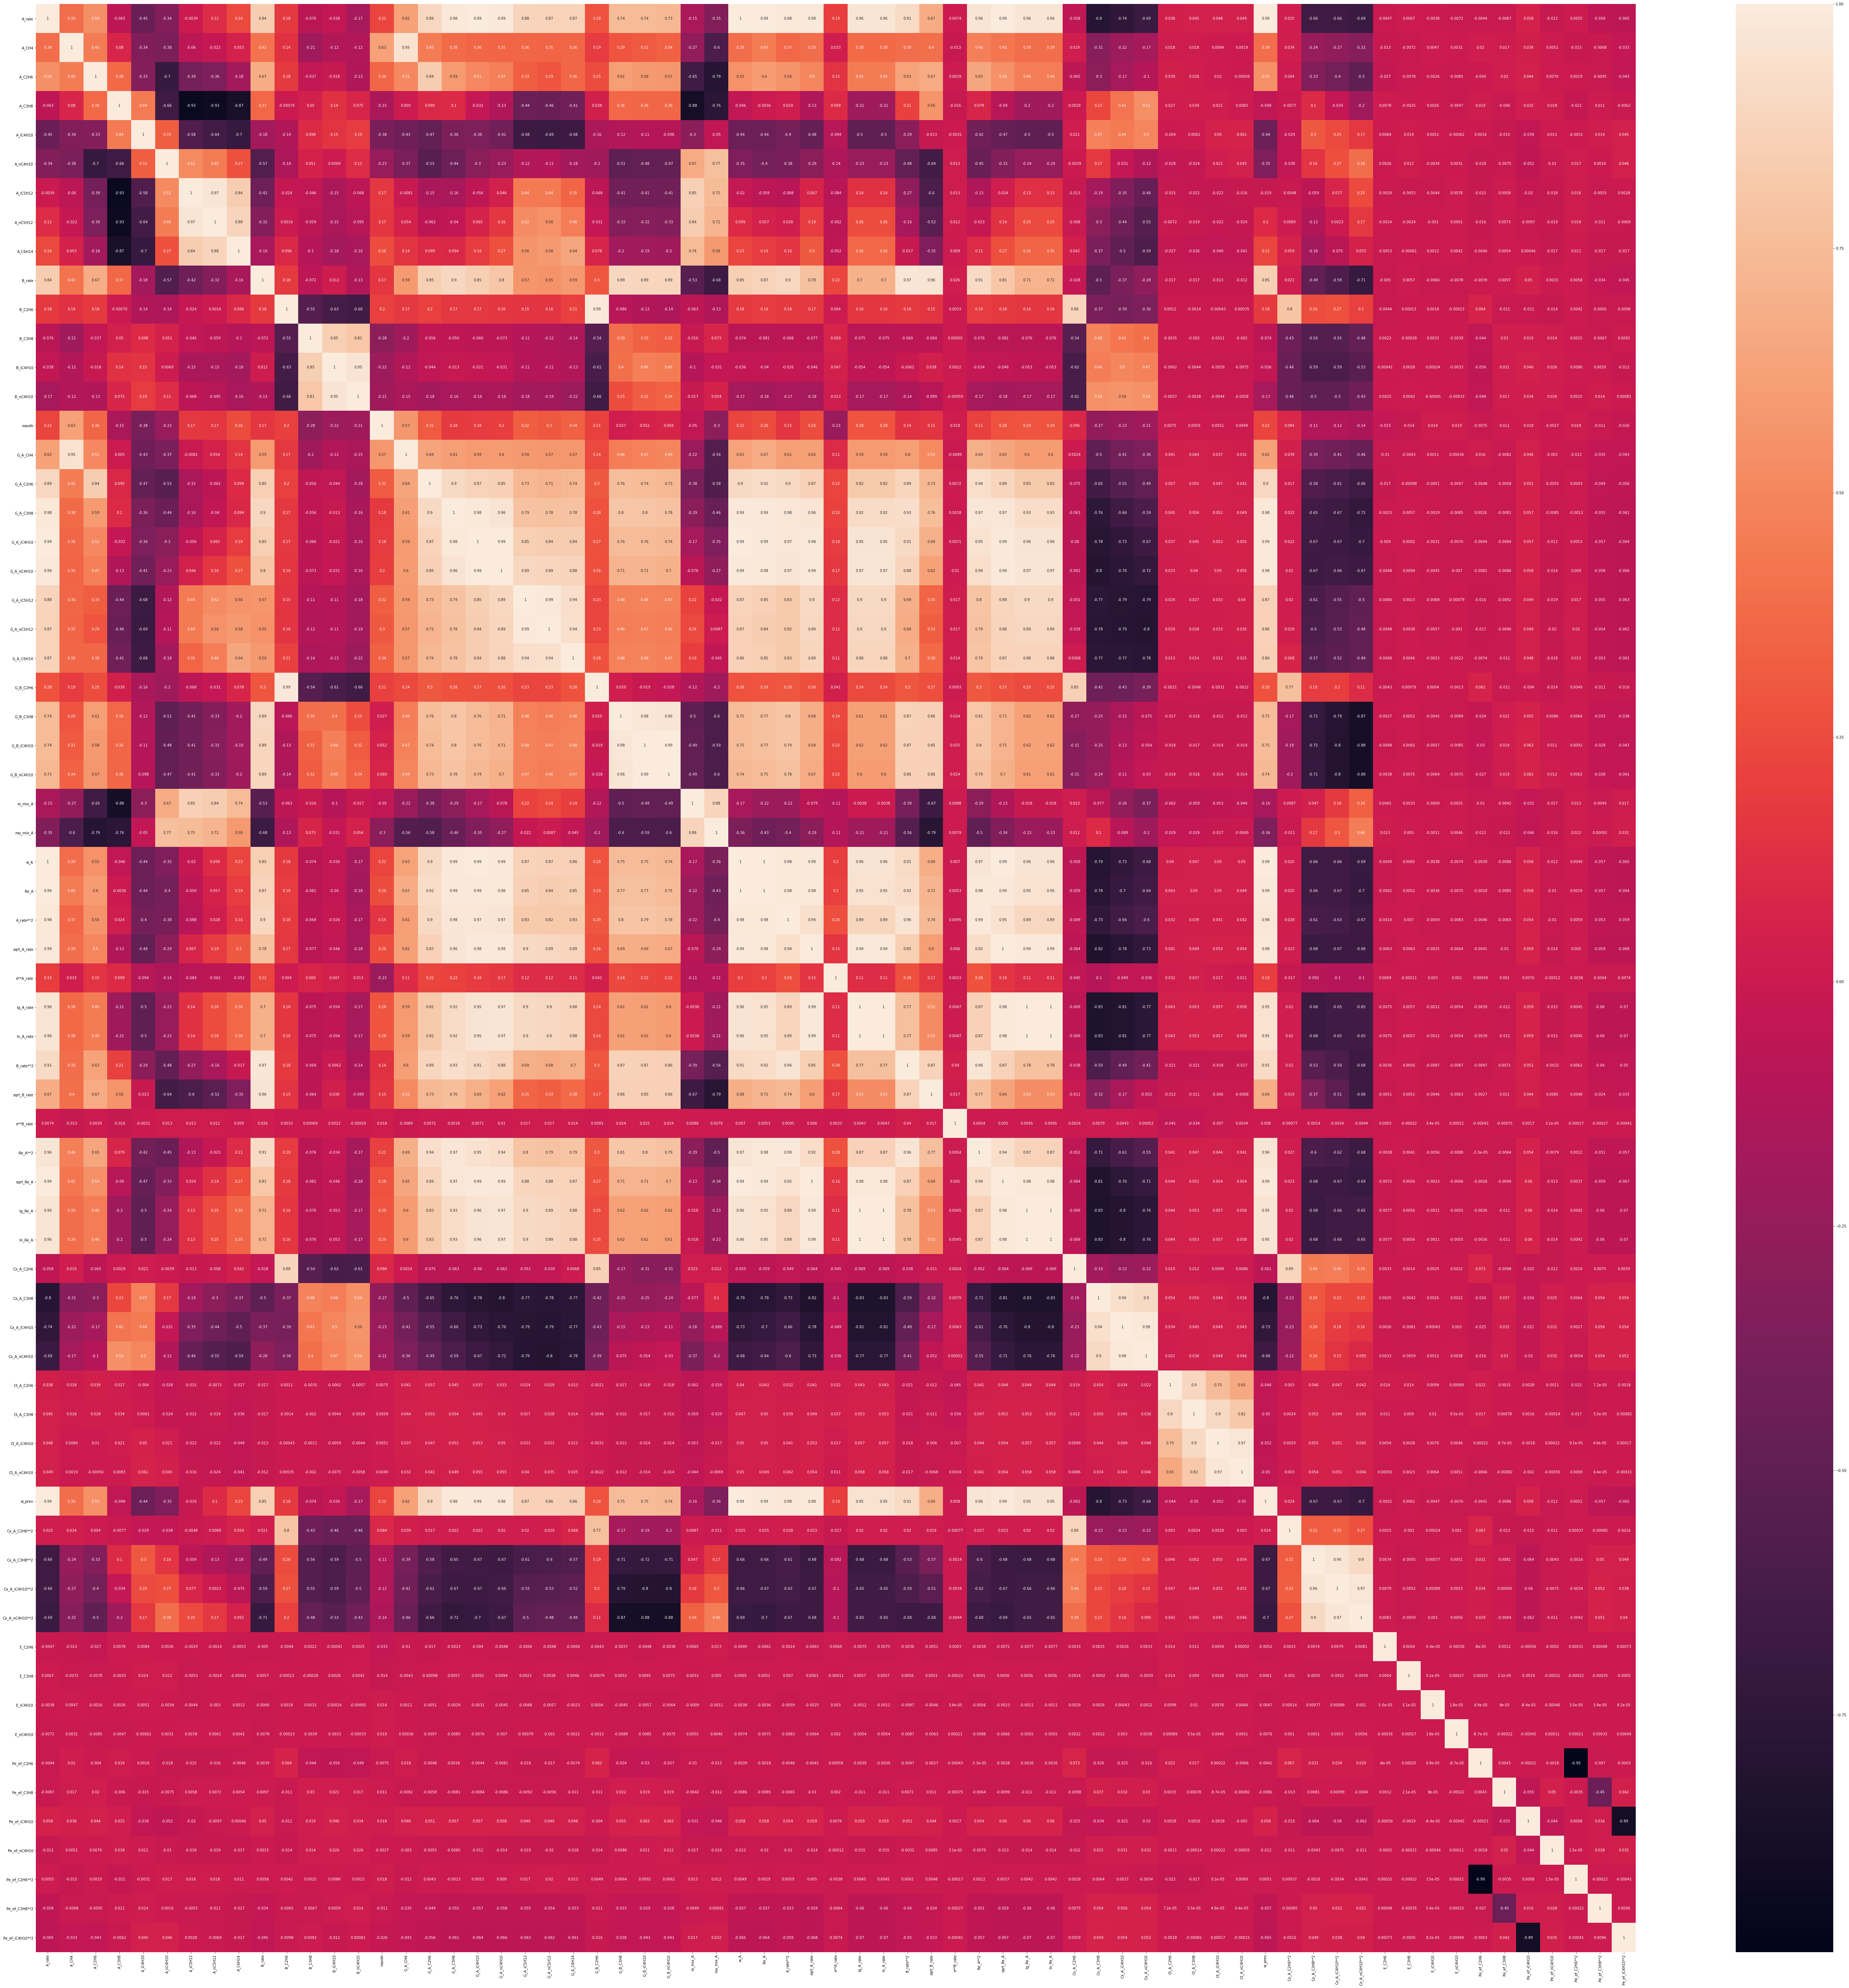

In [65]:
plt.figure(figsize=(100,100))
sns.heatmap(data.corr(), annot=True)

In [66]:
corrMatrix = pd.DataFrame()
corrMatrix['x'] = x.columns
corrMatrix['G_B_C2H6'] = np.array(x.corrwith(data['G_B_C2H6']))
corrMatrix['G_B_C3H8'] = np.array(x.corrwith(data['G_B_C3H8']))
corrMatrix['G_B_iC4H10'] = np.array(x.corrwith(data['G_B_iC4H10']))
corrMatrix['G_B_nC4H10'] = np.array(x.corrwith(data['G_B_nC4H10']))
corrMatrix['B_C2H6'] = np.array(x.corrwith(data['B_C2H6']))
corrMatrix['B_C3H8'] = np.array(x.corrwith(data['B_C3H8']))
corrMatrix['B_iC4H10'] = np.array(x.corrwith(data['B_iC4H10']))
corrMatrix['B_nC4H10'] = np.array(x.corrwith(data['B_nC4H10']))

In [67]:
corrMatrix

x  G_B_C2H6  G_B_C3H8  G_B_iC4H10  G_B_nC4H10    B_C2H6  \
0            A_rate  0.280661  0.743834    0.743984    0.728952  0.178839   
1             A_CH4  0.186387  0.290436    0.312601    0.341057  0.143355   
2            A_C2H6  0.253254  0.609825    0.583442    0.573839  0.180466   
3            A_C3H8  0.037808  0.364334    0.356669    0.356486 -0.000795   
4          A_iC4H10 -0.158360 -0.120078   -0.108839   -0.098126 -0.135928   
5          A_nC4H10 -0.202758 -0.505671   -0.482808   -0.471927 -0.142820   
6          A_iC5H12 -0.068229 -0.414842   -0.413335   -0.409690 -0.024370   
7          A_nC5H12 -0.030829 -0.328195   -0.322696   -0.325912  0.001550   
8           A_C6H14  0.078452 -0.195708   -0.192827   -0.202723  0.096260   
9            B_rate  0.295796  0.892104    0.889408    0.886209  0.175039   
10            month  0.207846  0.026505    0.051790    0.069399  0.202133   
11          G_A_CH4  0.242070  0.455246    0.474175    0.494623  0.173878   
12         G_A_C2H6  0.304219  0.762931    0.743786    0.727890  0.203389   
13         G_A_C3H8  0.280346  0.803591    0.799062    0.782316  0.172831   
14       G_A_iC4H10  0.270160  0.755084    0.757208    0.742356  0.167829   
15       G_A_nC4H10  0.262739  0.708781    0.714672    0.701470  0.164798   
16       G_A_iC5H12  0.226760  0.475494    0.480710    0.474415  0.154542   
17       G_A_nC5H12  0.227922  0.458177    0.466826    0.457029  0.157410   
18        G_A_C6H14  0.283699  0.477599    0.484312    0.469569  0.212610   
19         ro_mix_A -0.118920 -0.497932   -0.486430   -0.487336 -0.062961   
20         mu_mix_A -0.204376 -0.597759   -0.593868   -0.602779 -0.132032   
21              w_A  0.281989  0.751823    0.751296    0.736181  0.179355   
22             Re_A  0.291011  0.768047    0.766486    0.753144  0.186442   
23        A_rate**2  0.292931  0.797064    0.794774    0.779838  0.181088   
24      sqrt_A_rate  0.264795  0.686554    0.687889    0.672684  0.172264   
25        e**A_rate  0.041141  0.237203    0.223411    0.216551  0.004018   
26        lg_A_rate  0.243088  0.613582    0.615725    0.600354  0.161691   
27        ln_A_rate  0.243088  0.613582    0.615725    0.600354  0.161691   
28        B_rate**2  0.299258  0.868201    0.865014    0.857250  0.177522   
29      sqrt_B_rate  0.266770  0.856536    0.853621    0.856697  0.154633   
30        e**B_rate  0.009270  0.023951    0.024587    0.023771  0.003297   
31          Re_A**2  0.302854  0.807235    0.802036    0.789578  0.189987   
32        sqrt_Re_A  0.273068  0.709353    0.709782    0.695590  0.177873   
33          lg_Re_A  0.245525  0.620799    0.622859    0.607694  0.163281   
34          ln_Re_A  0.245525  0.620799    0.622859    0.607694  0.163281   
35        Cx_A_C2H6  0.853882 -0.268584   -0.312879   -0.313940  0.882841   
36        Cx_A_C3H8 -0.424866 -0.246215   -0.251398   -0.237686 -0.371847   
37      Cx_A_iC4H10 -0.425094 -0.148718   -0.125552   -0.110365 -0.387273   
38      Cx_A_nC4H10 -0.390188 -0.074664   -0.053718   -0.030116 -0.361842   
39        Ct_A_C2H6 -0.002112 -0.016683   -0.017867   -0.018247  0.001117   
40        Ct_A_C3H8 -0.004617 -0.015936   -0.016650   -0.016490 -0.001442   
41      Ct_A_iC4H10 -0.003140 -0.012044   -0.013870   -0.013628 -0.000429   
42      Ct_A_nC4H10 -0.002168 -0.011962   -0.013913   -0.013719  0.000345   
43           w_prev  0.282324  0.753527    0.753134    0.738020  0.179361   
44     Cx_A_C2H6**2  0.771159 -0.172182   -0.192389   -0.195161  0.795351   
45     Cx_A_C3H8**2  0.189657 -0.705098   -0.717852   -0.711363  0.255580   
46   Cx_A_iC4H10**2  0.195574 -0.792515   -0.803476   -0.801132  0.272633   
47   Cx_A_nC4H10**2  0.110516 -0.873421   -0.880711   -0.880461  0.199307   
48           E_C2H6 -0.004301 -0.003747   -0.004762   -0.003843 -0.004351   
49           E_C3H8  0.000787  0.005167    0.006495    0.007523  0.000135   
50         E_iC4H10  0.000395 -0.004469   -0.005715   -0.006387  0.001812   
51         E_n

In [68]:
for i in corrMatrix.drop(labels='x', axis=1).columns:
    print(i + ' = ' , sum(corrMatrix[i].apply(abs)))

G_B_C2H6 =  11.306305845833306
G_B_C3H8 =  23.758653173851588
G_B_iC4H10 =  23.799737049701868
G_B_nC4H10 =  23.502899325935182
B_C2H6 =  8.796468242653892
B_C3H8 =  7.031476422373811
B_iC4H10 =  6.886687740580905
B_nC4H10 =  9.40360486594049


In [69]:
corrMatrix[(corrMatrix['G_B_C2H6'] > 0.3) | (corrMatrix['G_B_C2H6'] < -0.3)][['x', 'G_B_C2H6']]

x  G_B_C2H6
12      G_A_C2H6  0.304219
31       Re_A**2  0.302854
35     Cx_A_C2H6  0.853882
36     Cx_A_C3H8 -0.424866
37   Cx_A_iC4H10 -0.425094
38   Cx_A_nC4H10 -0.390188
44  Cx_A_C2H6**2  0.771159

In [70]:
corrMatrix[(corrMatrix['G_B_C3H8'] > 0.3) | (corrMatrix['G_B_C3H8'] < -0.3)][['x', 'G_B_C3H8']]

x  G_B_C3H8
0           A_rate  0.743834
2           A_C2H6  0.609825
3           A_C3H8  0.364334
5         A_nC4H10 -0.505671
6         A_iC5H12 -0.414842
7         A_nC5H12 -0.328195
9           B_rate  0.892104
11         G_A_CH4  0.455246
12        G_A_C2H6  0.762931
13        G_A_C3H8  0.803591
14      G_A_iC4H10  0.755084
15      G_A_nC4H10  0.708781
16      G_A_iC5H12  0.475494
17      G_A_nC5H12  0.458177
18       G_A_C6H14  0.477599
19        ro_mix_A -0.497932
20        mu_mix_A -0.597759
21             w_A  0.751823
22            Re_A  0.768047
23       A_rate**2  0.797064
24     sqrt_A_rate  0.686554
26       lg_A_rate  0.613582
27       ln_A_rate  0.613582
28       B_rate**2  0.868201
29     sqrt_B_rate  0.856536
31         Re_A**2  0.807235
32       sqrt_Re_A  0.709353
33         lg_Re_A  0.620799
34         ln_Re_A  0.620799
43          w_prev  0.753527
45    Cx_A_C3H8**2 -0.705098
46  Cx_A_iC4H10**2 -0.792515
47  Cx_A_nC4H10**2 -0.873421

In [71]:
corrMatrix[(corrMatrix['G_B_iC4H10'] > 0.3) | (corrMatrix['G_B_iC4H10'] < -0.3)][['x', 'G_B_iC4H10']]

x  G_B_iC4H10
0           A_rate    0.743984
1            A_CH4    0.312601
2           A_C2H6    0.583442
3           A_C3H8    0.356669
5         A_nC4H10   -0.482808
6         A_iC5H12   -0.413335
7         A_nC5H12   -0.322696
9           B_rate    0.889408
11         G_A_CH4    0.474175
12        G_A_C2H6    0.743786
13        G_A_C3H8    0.799062
14      G_A_iC4H10    0.757208
15      G_A_nC4H10    0.714672
16      G_A_iC5H12    0.480710
17      G_A_nC5H12    0.466826
18       G_A_C6H14    0.484312
19        ro_mix_A   -0.486430
20        mu_mix_A   -0.593868
21             w_A    0.751296
22            Re_A    0.766486
23       A_rate**2    0.794774
24     sqrt_A_rate    0.687889
26       lg_A_rate    0.615725
27       ln_A_rate    0.615725
28       B_rate**2    0.865014
29     sqrt_B_rate    0.853621
31         Re_A**2    0.802036
32       sqrt_Re_A    0.709782
33         lg_Re_A    0.622859
34         ln_Re_A    0.622859
35       Cx_A_C2H6   -0.312879
43          w_prev    0.753134
45    Cx_A_C3H8**2   -0.717852
46  Cx_A_iC4H10**2   -0.803476
47  Cx_A_nC4H10**2   -0.880711

In [72]:
corrMatrix[(corrMatrix['G_B_nC4H10'] > 0.3) | (corrMatrix['G_B_nC4H10'] < -0.3)][['x','G_B_nC4H10']] 

x  G_B_nC4H10
0           A_rate    0.728952
1            A_CH4    0.341057
2           A_C2H6    0.573839
3           A_C3H8    0.356486
5         A_nC4H10   -0.471927
6         A_iC5H12   -0.409690
7         A_nC5H12   -0.325912
9           B_rate    0.886209
11         G_A_CH4    0.494623
12        G_A_C2H6    0.727890
13        G_A_C3H8    0.782316
14      G_A_iC4H10    0.742356
15      G_A_nC4H10    0.701470
16      G_A_iC5H12    0.474415
17      G_A_nC5H12    0.457029
18       G_A_C6H14    0.469569
19        ro_mix_A   -0.487336
20        mu_mix_A   -0.602779
21             w_A    0.736181
22            Re_A    0.753144
23       A_rate**2    0.779838
24     sqrt_A_rate    0.672684
26       lg_A_rate    0.600354
27       ln_A_rate    0.600354
28       B_rate**2    0.857250
29     sqrt_B_rate    0.856697
31         Re_A**2    0.789578
32       sqrt_Re_A    0.695590
33         lg_Re_A    0.607694
34         ln_Re_A    0.607694
35       Cx_A_C2H6   -0.313940
43          w_prev    0.738020
45    Cx_A_C3H8**2   -0.711363
46  Cx_A_iC4H10**2   -0.801132
47  Cx_A_nC4H10**2   -0.880461

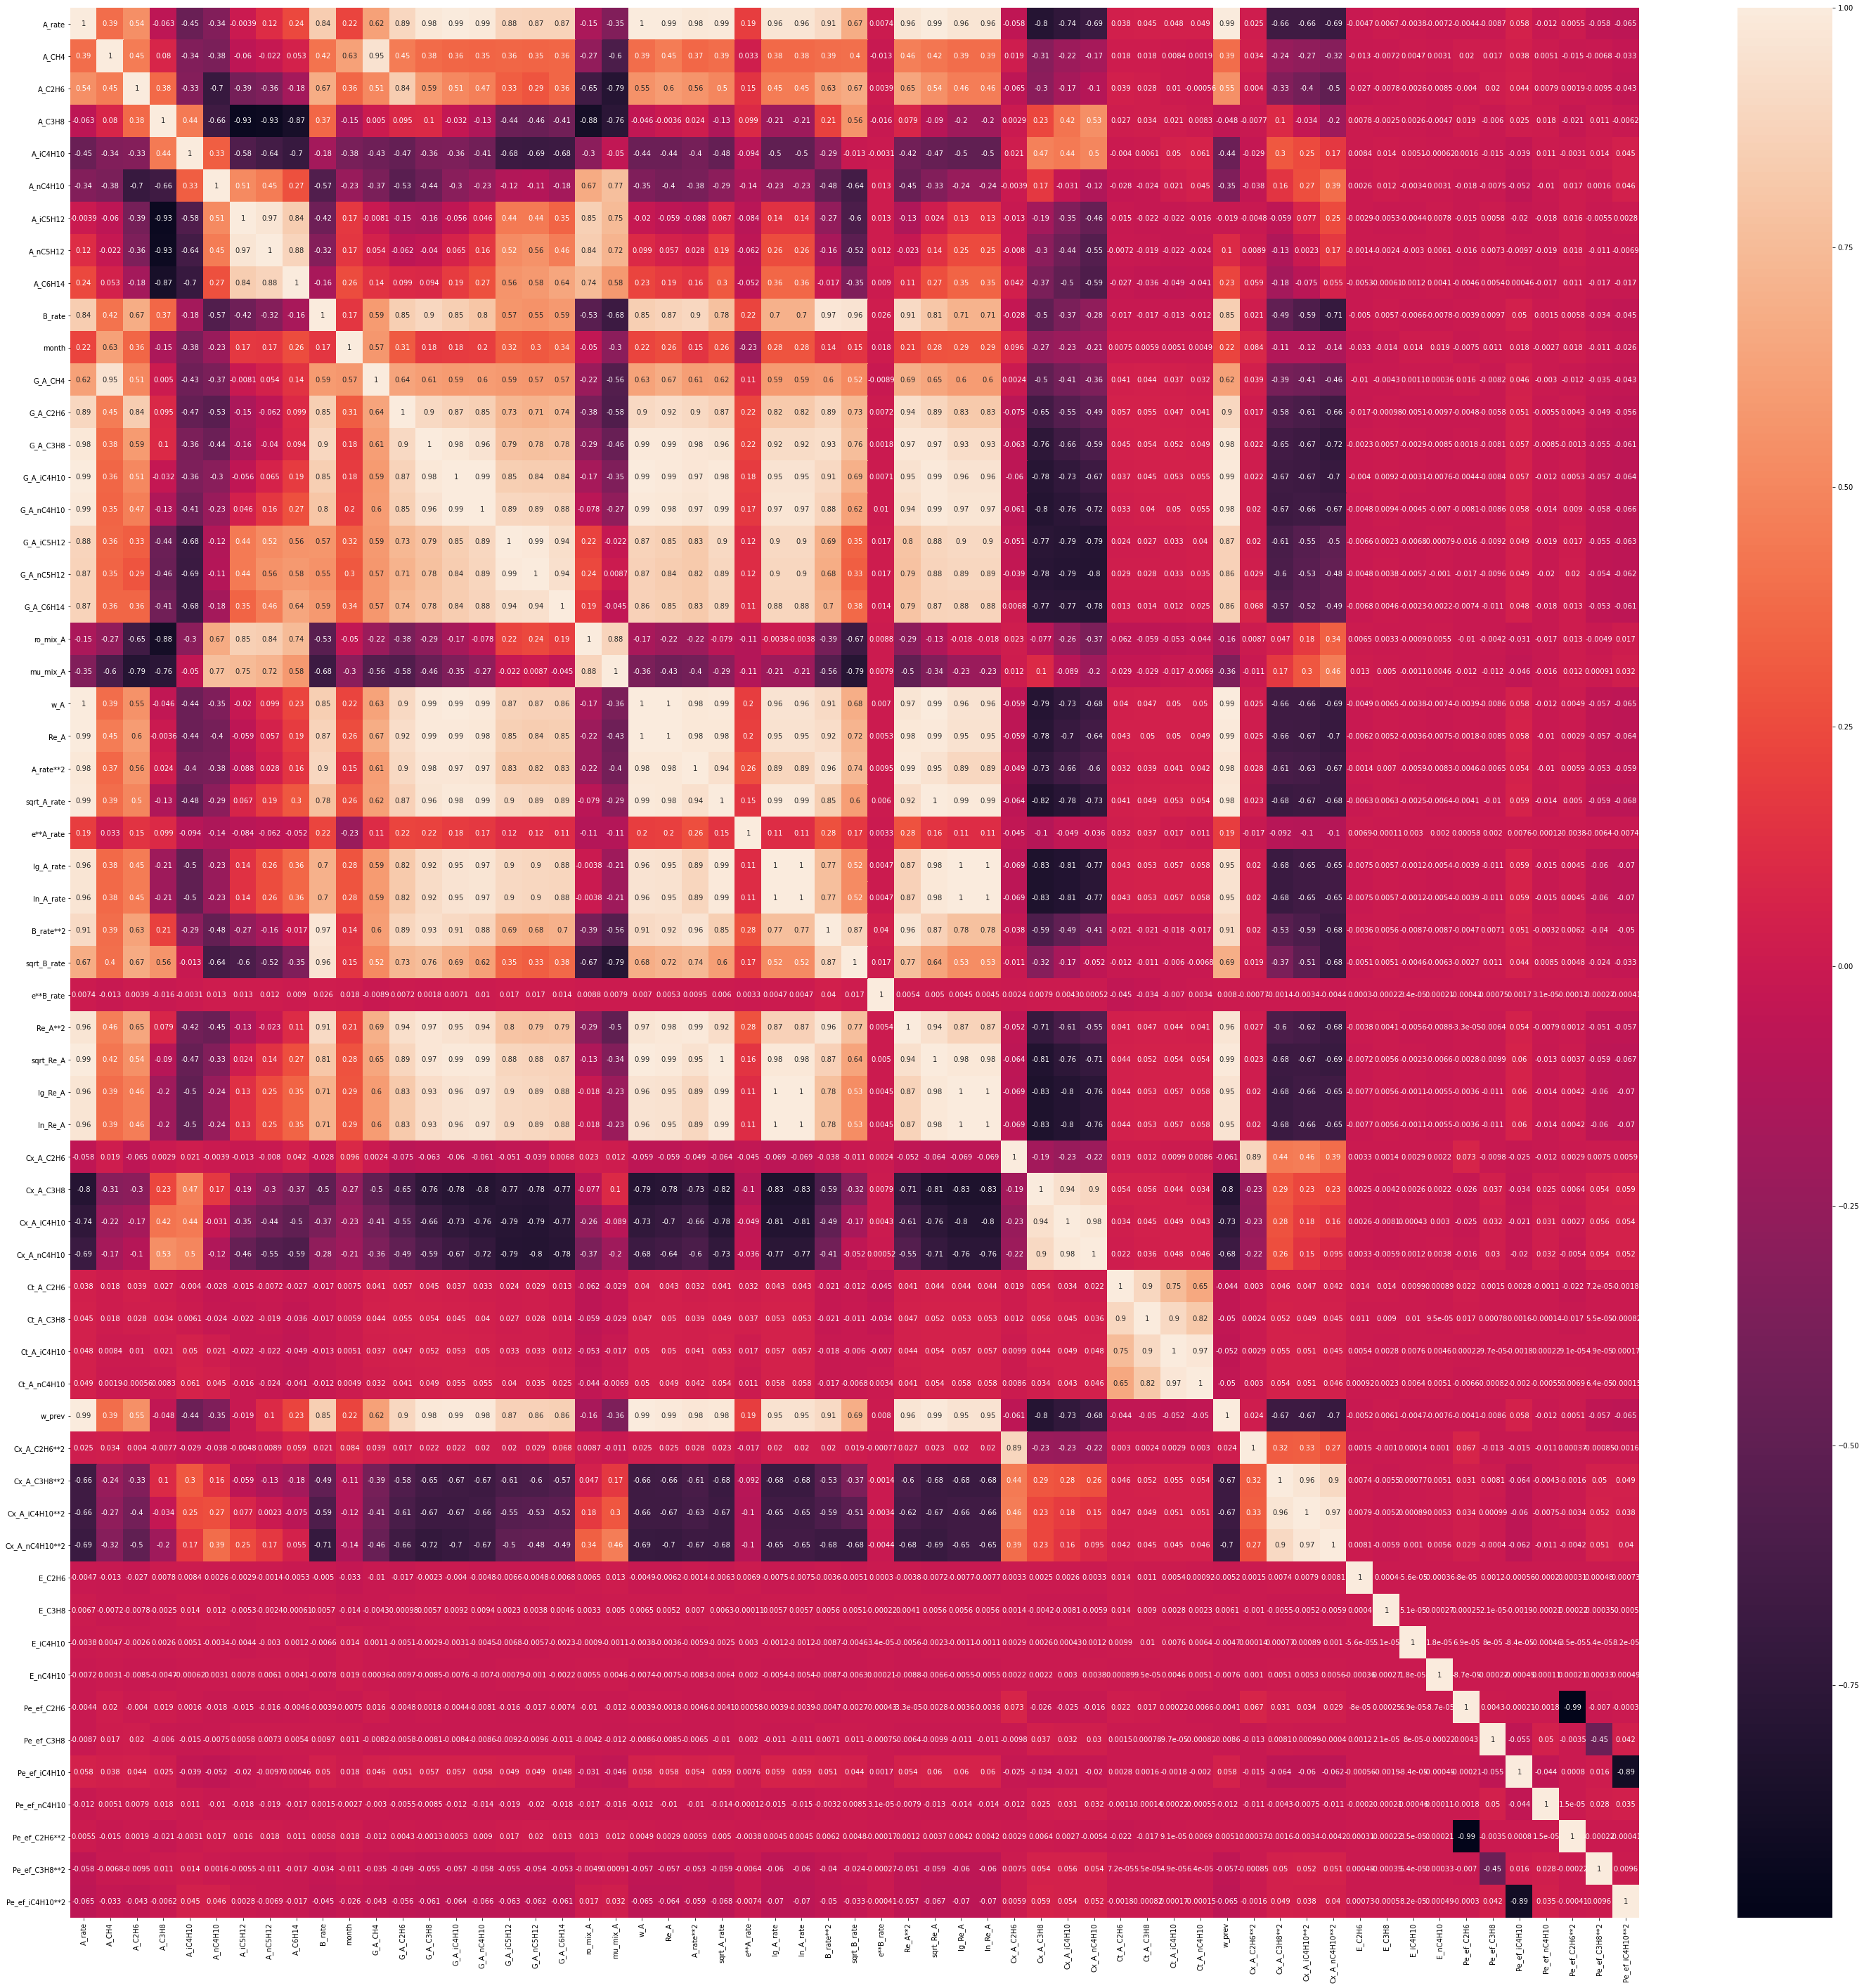

In [73]:
plt.figure(figsize=(50,50))
sns.heatmap(x.corr(), annot=True)

In [74]:
#запись DataFrame в файл
#data.to_csv('train_data.csv', sep=',', header=True, index=False)

1. ГОСТ 28656-90
2. "Природные и искусственные газы. Учебник для техникумов. 4-е изд. 1978 г" Рябцев Н.И.
3. Wikipedia

In [75]:
#!cat train_data.csv